In [2]:
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor 
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern
from scipy.stats import norm
import random
from scipy.stats import multivariate_normal
from multiprocessing import Pool
import workers
import time
import itertools
from math import comb
import warnings
import matplotlib.pyplot as plt 
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
predictors = [c for c in train.columns if c not in ['FloodProbability', 'id']]

In [5]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
train_drop_y_na = train[~(train['FloodProbability'].isna())]
imp_mean.fit(train_drop_y_na[predictors])
train_imputed = pd.DataFrame(imp_mean.transform(train_drop_y_na[predictors]))
train_imputed.columns = predictors

In [6]:
X_train, X_test, y_train, y_test = train_test_split(train_imputed, train_drop_y_na['FloodProbability'], 
                                                    test_size=0.33, random_state=42)

In [7]:
def r2(p, y_test):
    mu = np.mean(y_test)
    SSE = np.mean([(prediction-truth)**2 for prediction, truth in zip(p, y_test)])
    SST = np.mean([(prediction-mu)**2 for prediction, truth in zip(p, y_test)])
    return max(1-SSE/SST, -10)


In [8]:
max_iterations = 300
def nn(alpha, momentum, hidden_layer, X_train, y_train, X_test, y_test):
    regr_sgd = MLPRegressor(random_state=1, max_iter=max_iterations, solver='sgd', 
                            hidden_layer_sizes = hidden_layer,
                            alpha = alpha,
                            learning_rate = 'adaptive',
                            momentum=momentum, 
                            nesterovs_momentum = True).fit(X_train, y_train)
    score = r2(regr_sgd.predict(X_test), y_test)
    return score 



In [9]:
kernel = DotProduct()+ WhiteKernel()
N = 5000

In [10]:
#initialize with random points
performance = []
layers = [tuple([np.random.randint(14) * 4 + 2 for a in range(5)]) 
          for t in range(10)]
for layer in layers:
    performance.append(nn(.001, .95, layer, 
                          X_train[0:N], y_train[0:N], X_test, y_test) )

In [25]:
layers = layers[0:10]
performance = performance[0:10]

In [26]:
output_df = pd.DataFrame(layers)
output_df['r2'] = performance
output_df.sort_values('r2', ascending=False)

,0,1,2,3,4,r2
9,45,49,37,25,45,0.380730
7,41,5,21,45,53,-0.859337
4,25,5,33,33,21,-1.324143
3,13,49,25,5,53,-1.468136
8,9,13,53,45,53,-2.865812
0,5,33,29,49,25,-3.688175
1,9,1,13,45,37,-10.000000
2,21,49,49,37,5,-10.000000
5,1,25,21,41,33,-10.000000
6,1,41,25,45,49,-10.000000


In [27]:
iteration = [0] * len(performance)
best_y = max(performance)

In [36]:
BatchSize = 1000
train_time = []
krig_time = []
bayes = True
new_points = [tuple([np.random.randint(14) * 4 + 2 for a in range(5)]) for t in range(100)]
if __name__ ==  '__main__': 

    num_processors = 8 
    p = Pool(processes = num_processors)

    for itrx in range(50, 51):
        print("Iteration: " + str(itrx))
        next = random.sample(new_points, num_processors)
        
        start = time.time()
        parameters = []
        for layer in next:
            parameters.append({'alpha': .001, 'momentum': .95, "X_train": X_train[0:N], 
                               "y_train": y_train[0:N],'max_iter': max_iterations,
                               "X_test": X_test, "y_test": y_test, "hidden_layer": layer})
        output = p.map(workers.nn,[i for i in parameters])
        train_time.append(time.time()-start)
        
        print("    train time {}".format(round(time.time()-start,4)))
        
        # add results of new points
        for o in output:
            # put 0 back in; kriging does use it
            print("    r2: {}, points: {}".format(round(o[0], 3), o[1]))
            performance.append(o[0])
            iteration.append(itrx)
            if len(o[1]) < 5:
                x = list(o[1])
                x.append(0)
                layers.append(tuple(x))
            else:
                layers.append(o[1])
                
        BO = pd.DataFrame(layers)
        BO.columns = ['first', 'second', 'third', 'fourth', 'fifth']
        BO['performance'] = performance
        BO['iteration'] = iteration
        
        print(BO.sort_values('performance', ascending=False).head())
        
        gpr = GaussianProcessRegressor(kernel=kernel,random_state=0)
        gpr.fit(layers, performance)
        if bayes:
            # optimize krig model
            start = time.time()
    
#            next_points = [tuple([np.random.randint(10) * 5 + 1 for a in range(5)]) for t in range(BatchSize*num_processors)]
            next_points = [tuple([np.random.randint(14) * 4 + 1 for a in range(5)]) for t in range(BatchSize*num_processors)]
            print("    batch size {}".format(len(next_points)))
            mu, sigma = gpr.predict(next_points, return_cov=True)
            #mu, sigma = OB.krig(next_points)
    
            qEI_batches = [] 
            for n in range(num_processors):    
    
                # create a batch for qEI to search through
                # each row is a group from the "master pool of groupings"
                # sub subprocess will check all the groupings in the batch
                
                B = []
                for z in range(BatchSize):
                    B.append(random.sample(range(len(next_points)), num_processors))
#                B = [list(b) for b in next_points[(n*BatchSize):((n+1)*BatchSize)]]
                qEI_batches.append({'new_points': B, 
                                    'y_best': best_y, 'qc': False,
                                    'multivariate': True,
                                    'q': num_processors, 'mu': mu, 'sigma': sigma}) 
    
            output2 = p.map(workers.qEI,[i for i in qEI_batches])
            krig_time.append(time.time()-start)
            print("    optimize GP time {}".format(round(time.time()-start,4)))
            
            #new_points =  [x[1] for x in output2]
            top_points = pd.DataFrame(output2)
            top_points.columns = ['score', 'points']
            new_points = [next_points[x] for x in top_points.sort_values('score', ascending=False)['points'][0]]
        else:
            new_points = [tuple([np.random.randint(14) * 4 + 1 for a in range(5)]) for t in range(num_processors)]


Iteration: 50
    train time 16.3317
    r2: 0.199, points: (14, 14, 46, 50, 10)
    r2: -0.529, points: (46, 14, 14, 26, 50)
    r2: -10, points: (54, 30, 2, 46, 46)
    r2: -1.355, points: (14, 42, 6, 30, 50)
    r2: -0.142, points: (22, 38, 50, 14, 10)
    r2: 0.186, points: (50, 50, 54, 26, 26)
    r2: 0.549, points: (38, 22, 34, 26, 30)
    r2: 0.345, points: (38, 46, 46, 38, 42)
     first  second  third  fourth  fifth  performance  iteration
89      37      49     17      53      5     0.588392         10
96      45      45     53      49     53     0.577258         11
122     45      41     17      53     13     0.576349         15
228     45       9     29      53      9     0.574641         28
408     38      22     34      26     30     0.549265         50
    batch size 8000
    optimize GP time 26.4957


In [29]:
print(BO.sort_values('performance', ascending=False)[5:22])

     first  second  third  fourth  fifth  performance  iteration
123     33      25     41      49      5     0.540476         15
152     53      37     49      53     17     0.529491         18
350     41      49     53      33     17     0.511923         43
334     45      33     49      53     45     0.508269         41
278     53      29     49      49     53     0.504277         34
293     41      49     37      21     21     0.500995         36
57      53      49     41      53     41     0.481186          6
262     53      41     53      49     45     0.479276         32
238     21      53     25      53     41     0.479243         29
206     53      41     45      53     49     0.474355         25
182     45      53     49      37     53     0.454034         22
51      37      25     17      29     41     0.452636          6
256     53      41     41      45     49     0.447770         31
337     45      49     29      21     49     0.446188         41
98      53      41     53

<Axes: >

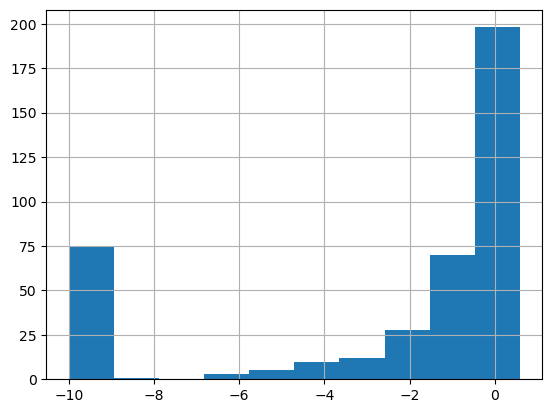

In [30]:
BO['performance'].hist()

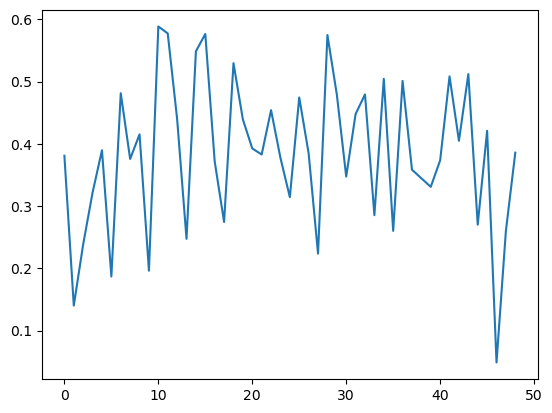

In [31]:
IxP = BO[['iteration', 'performance']].groupby(iteration).max()
y = [p for p in IxP['performance'] if p > 0]
x = [i for i,p in zip(IxP['iteration'], IxP['performance']) if p > 0]
plt.plot(x, y)


In [32]:
pd.DataFrame({'iteration': x, 'performance': y}).to_csv('iteration_performance_bayes.csv', index=False)

In [33]:
BO = pd.DataFrame(layers)
BO.columns = ['first', 'second', 'third', 'fourth', 'fifth']
BO['performance'] = performance
BO['iteration'] = iteration

In [22]:
for l in ['first', 'second', 'third', 'fourth', 'fifth']:
    print(BO[[l, 'performance']].groupby(l).max())


       performance
first             
1       -10.000000
5        -0.317453
9        -1.043043
13        0.384031
17        0.444829
21        0.480243
25        0.557239
29        0.461115
33        0.414213
37        0.562273
41        0.210079
45        0.483991
49        0.499926
53        0.552934
        performance
second             
1         -0.171430
5          0.482576
9          0.450029
13         0.443828
17         0.444829
21         0.387446
25         0.411384
29         0.404445
33         0.471859
37         0.461115
41         0.562273
45         0.534602
49         0.499926
53         0.557239
       performance
third             
1        -3.336849
5         0.225059
9         0.557239
13        0.450029
17        0.434994
21        0.562273
25        0.444829
29        0.480243
33        0.483991
37        0.380730
41        0.534602
45        0.471859
49        0.237779
53        0.499926
        performance
fourth             
1          0.210079
5          0

In [34]:
#random_BO = BO
bayes_BO = BO

In [35]:
print(sum(train_time))
print(sum(krig_time))

4547.391566753387
4287.691624164581


In [62]:
#bayes_BO[bayes_BO['iteration'] == 0]

NameError: name 'bayes_BO' is not defined